# Bayse Model

In [19]:
import os
os.environ['PYTENSOR_FLAGS'] = 'blas_ldflags='

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
import numpyro
import numpyro.distributions as dist
from numpyro.infer import MCMC, NUTS, Predictive
import jax
jax.config.update("jax_platform_name", "cpu")
import jax.numpy as jnp
import pymc as pm
import arviz as az
from graphviz import Digraph

In [14]:
filepath = "../../../data/processed/df_filtered_5years.xlsx"
df = pd.read_excel(filepath)
df['population_change_rate'] = df.groupby('island_id')['population'].pct_change()
df['log_income'] = np.log(df['income'])
df = df.dropna()

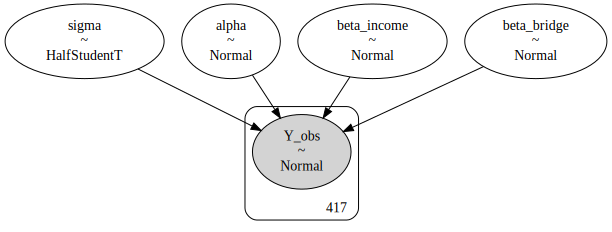

In [22]:
population = df['population_change_rate'].values
bridge = df['dummy_after_bridge_build'].values
log_income = df['log_income'].values

with pm.Model() as model:
    # Priors
    alpha = pm.Normal('alpha', mu=0.0256, sigma=100)
    beta_bridge = pm.Normal('beta_bridge', mu=0.066, sigma=100)
    beta_income = pm.Normal('beta_income', mu=-0.0115, sigma=100)
    sigma = pm.HalfStudentT('sigma', nu=4, sigma=100)

    # linear model
    mu = alpha + beta_bridge * bridge + beta_income * log_income

    # Likelihood
    Y_obs = pm.Normal('Y_obs', mu=mu, sigma=sigma, observed=population)

# モデルの視覚化
graph = pm.model_to_graphviz(model)
graph.render(filename='../../visualization/graphviz/bayeisan_model_5years', format='png', cleanup=True)
graph

In [25]:
with model:
    idata = pm.sample(
        draws=10000,
        tune=1000,
        nuts_sampler="numpyro",
        return_inferencedata=True,
        chains=4,
        target_accept=.95,
    )


  0%|          | 0/13000 [00:00<?, ?it/s]

  0%|          | 0/13000 [00:00<?, ?it/s]

  0%|          | 0/13000 [00:00<?, ?it/s]

  0%|          | 0/13000 [00:00<?, ?it/s]

In [26]:
az.to_netcdf(idata, 'normal_5years.nc')

'normal_5years.nc'

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
alpha,0.026,0.072,-0.111,0.158,0.001,0.0,14613.0,18009.0,1.0
beta_bridge,0.066,0.015,0.038,0.094,0.000,0.0,23876.0,22398.0,1.0
beta_income,-0.012,0.004,-0.019,-0.004,0.000,0.0,14461.0,18338.0,1.0
sigma,0.129,0.005,0.121,0.138,0.000,0.0,23482.0,20895.0,1.0


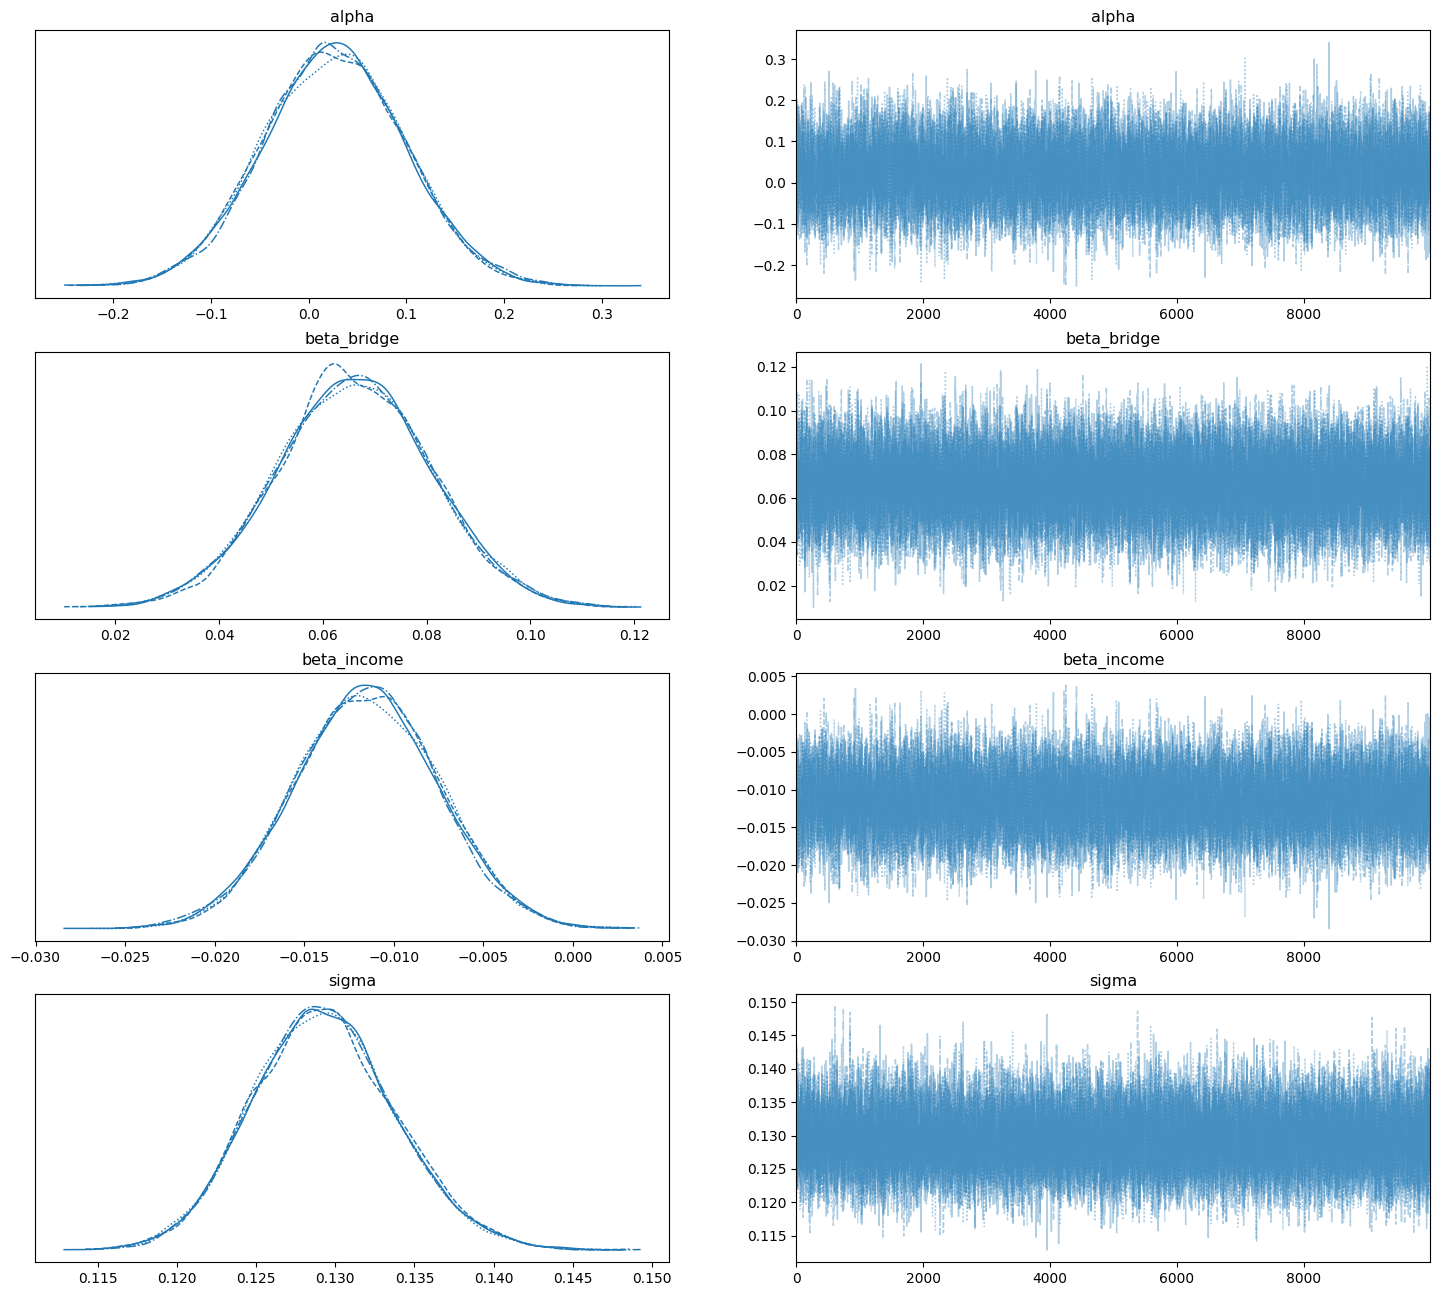

In [31]:
az.plot_trace(idata, figsize=(18, 16))  # サイズを調整
az.summary(idata)

In [35]:
# モデルとトレースが既に得られていると仮定
with model:
    # ポストリア予測サンプルを生成
    ppc = pm.sample_posterior_predictive(idata)

Sampling: [Y_obs]


Output()

In [36]:
idata.extend(ppc)

Exception ignored in: <function tqdm.__del__ at 0x7f0a42b57760>
Traceback (most recent call last):
  File "/home/keisei/data-analysis/bridge-straw-effects/.venv/lib/python3.10/site-packages/tqdm/std.py", line 1148, in __del__
    self.close()
  File "/home/keisei/data-analysis/bridge-straw-effects/.venv/lib/python3.10/site-packages/tqdm/notebook.py", line 279, in close
    self.disp(bar_style='danger', check_delay=False)
AttributeError: 'tqdm' object has no attribute 'disp'


<Figure size 1200x600 with 0 Axes>

/home/keisei/data-analysis/bridge-straw-effects/.venv/lib/python3.10/site-packages/IPython/core/pylabtools.py:170: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


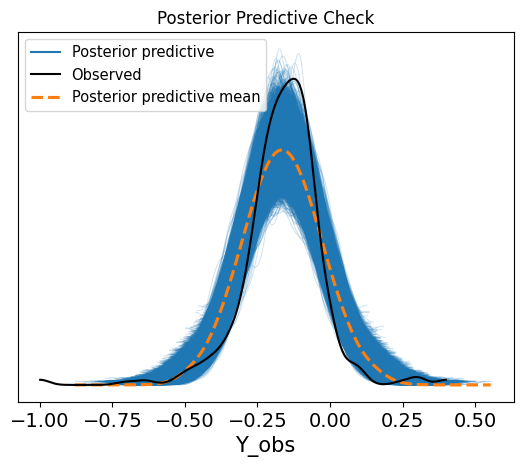

In [37]:
# PPCプロットを生成
plt.figure(figsize=(12, 6))
az.plot_ppc(idata, group="posterior")
plt.title("Posterior Predictive Check")
plt.legend(loc="upper right")
plt.show()


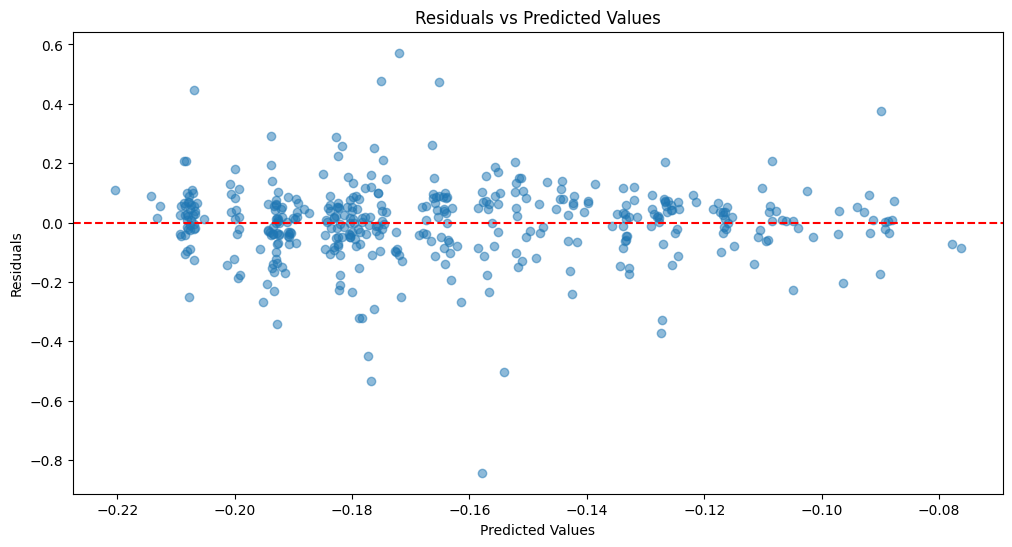

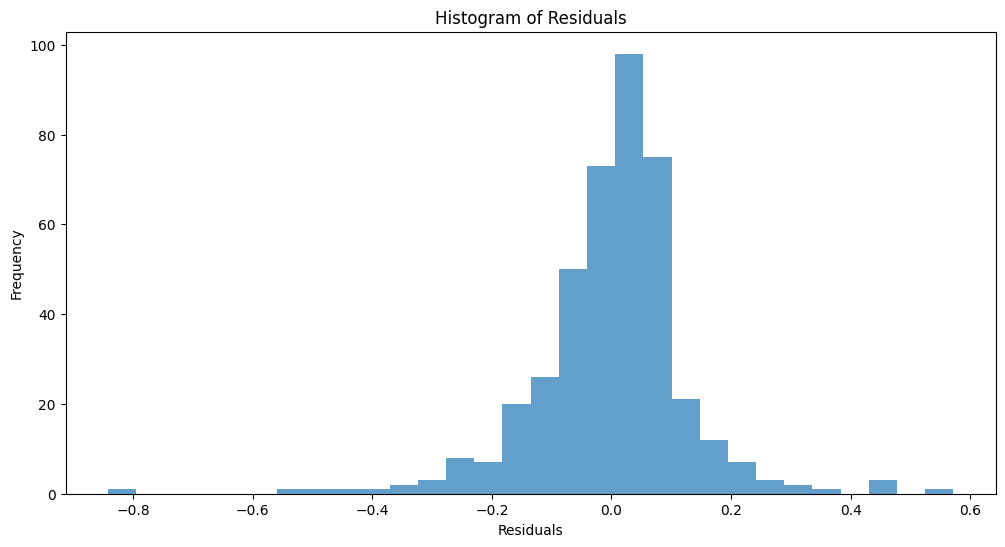

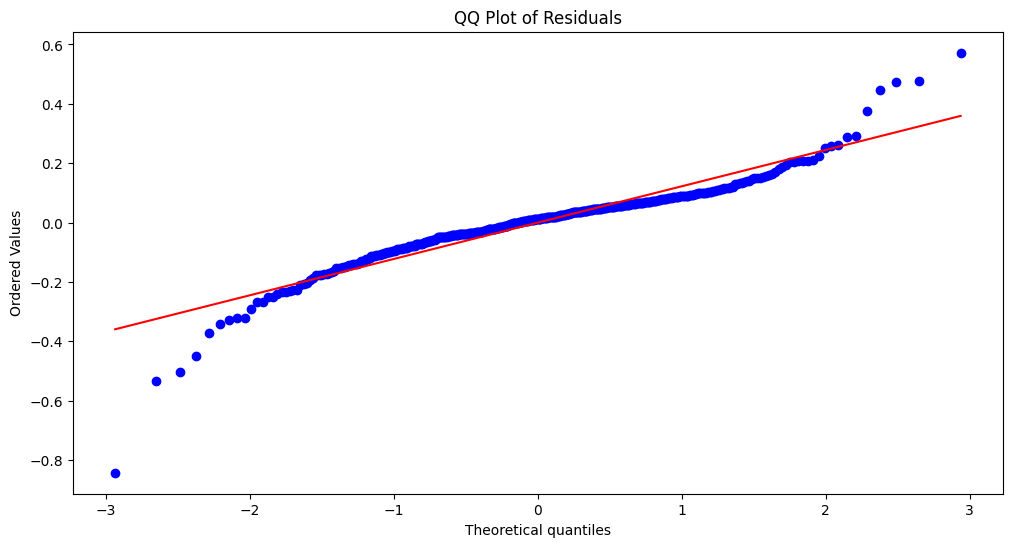

In [39]:
# 予測値の抽出
posterior_predictive = idata.posterior_predictive["Y_obs"].mean(dim=["chain", "draw"]).values

# 観測値の抽出
observed_data = idata.observed_data["Y_obs"].values

# 残差の計算
residuals = observed_data - posterior_predictive

# 残差のプロット
plt.figure(figsize=(12, 6))
plt.scatter(posterior_predictive, residuals, alpha=0.5)
plt.axhline(0, color='red', linestyle='--')
plt.xlabel("Predicted Values")
plt.ylabel("Residuals")
plt.title("Residuals vs Predicted Values")
plt.show()

# 残差のヒストグラム
plt.figure(figsize=(12, 6))
plt.hist(residuals, bins=30, alpha=0.7)
plt.xlabel("Residuals")
plt.ylabel("Frequency")
plt.title("Histogram of Residuals")
plt.show()

# 残差のQQプロット
import scipy.stats as stats
plt.figure(figsize=(12, 6))
stats.probplot(residuals, dist="norm", plot=plt)
plt.title("QQ Plot of Residuals")
plt.show()

# 橋ダミーのパラメータが0以上である確率

In [34]:
posterior_samples = idata.posterior

beta_bridge_samples = posterior_samples['beta_bridge']

# 0以上のサンプルの割合を計算
prob_beta_bridge_positive = np.mean(beta_bridge_samples >= 0)

print(f"P(beta_1 >= 0) = {prob_beta_bridge_positive:.4f}")

P(beta_1 >= 0) = 1.0000
